In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Joachim DAVID, December 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
# @book{ebeling2004introduction,
#   title={An introduction to reliability and maintainability engineering},
#   author={Ebeling, C.E.},
#   isbn={9780070421387},
#   series={Electrical engineering series},
#   url={https://books.google.be/books?id=iFumyeVLIEAC},
#   year={2004},
#   publisher={McGraw-Hill}
# }

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)
from visualize_lib import plot_gantt, show_energy_plot
from datetime import datetime, timedelta

#%cd D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\original_data

#print(sys.path[0])
#import matplotlib
#matplotlib.matplotlib_fname()

filepath = 'original_data'
choices = {0: ('productionfile.csv', 'prod_speed.csv'),
           1: ('packagingfile_old.csv', 'pack_speed.csv')}
choice = choices[0]
file_used = choice[0]
file_speed = choice[1]

round_to = 600 # seconds
break_pauses = 7200 # seconds # breaks will be split in these periods
turn_off_if = 3600 # seconds # the machine can be turned off if time if larger than this!!!! 
# turn_off_if has to be smaller than break_pauses in order for this program to run well
assert (turn_off_if < break_pauses)

In [3]:
filename = os.path.join(filepath, file_used)
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
all_reasons = list(df.ReasonId.unique())
all_reasons.sort()
print(all_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


In [7]:
# VARIABLES
# cutoff_perc = 100
# dtcutoff_perc = 100
reasons_relative = [1, 3, 5, 7, 8]
reasons_absolute = [9, 10, 11]
reasons_break = [2]
reasons_not_considered = [0]
considered_reasons = reasons_relative + reasons_absolute + reasons_break
# group = True
choice='PastaType'

# PLOT_RANGE:
plotrange = datetime(2016, 11, 3, 6, 0), datetime(2016, 12, 3, 0, 0)

assert (set(considered_reasons + reasons_not_considered) == set(all_reasons))

In [8]:
def add_column_type(df, from_col='ArticleName', choice='BigPack'):
    choices = ['BigPack', 'Marque', 'PastaType']
    newname = choice

    if newname == choices[0]:
        stringlist = [' 8', ' 10', ' 12', ' 16', ' 18' ,' 20']
    elif newname == choices[1]:
        stringlist = ['DLL 365', 'VALUE', 'AMBRA', 'EVERYDAY', 'WINNY', 'CARREFOUR', 'ALDI', 'ECO+', 'TOSCA', 'CASA ITALIANA',
                     'EUROSHOPPER', 'AH', 'PASTA MARE', 'OKE', 'TOP BUDGET', 'FIORINI', 'BIO VILLAGE', 'MONOPP', 'RINATURA',
                     'JUMBO', 'BONI', 'CASINO', 'TURINI']
    elif newname == choices[2]:
        stringlist = [['MACARONI', 'MAC.'], 'FUSILLI', ['SPIRELLI', 'SPIRAL', 'TORSADES', 'HORENTJE', 'HELICES'], 
                      ['VERMICELLI', 'VERMICELL'], ['NOODLES', 'NOUILLES'], 'TORTI',
                     ['PENNE', 'PIPE'], ['ELLEBOOGJES', 'COQUILLETTE', 'COQ.'], 'ZITTI', 'MIE', 'NONE']
    else:
        raise NameError("The choice '{}' is not defined".format(newname))
    
    # Generate a new column with categories in the dataframe
    bp = np.full(df.shape[0], 'Other')
    name = df[from_col]
    for s in stringlist:
        if type(s) == list:
            new_s = ('|'.join(s))
            bp = np.where(name.str.contains(new_s), s[0], bp)
        else:
            if newname == 'BigPack':
                bp = np.where(name.str.contains(s), s + 'X', bp)
            else:
                bp = np.where(name.str.contains(s), s, bp)
    df[newname] = bp
    return df
df = add_column_type(df, choice=choice)

In [9]:
df.head(3)

,EquipmentId,ProductionRequestId,SegmentResponseId,StartDateUTC,EndDateUTC,Duration,ReasonId,IgnoreType,ArticleCode,ArticleName,Type,Quantity,PastaType
0,50,50675.0,74525.0,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64.0,10,0,FF029001,MACARONI KORT PLATTE ZAK,DownTime,30000,MACARONI
1,50,50675.0,74525.0,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860.0,1,0,FF029001,MACARONI KORT PLATTE ZAK,RunTime,30000,MACARONI
2,50,50675.0,74525.0,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414.0,8,0,FF029001,MACARONI KORT PLATTE ZAK,DownTime,30000,MACARONI


### Export for simulator file and visualise

In [10]:
def add_breaks(production, maxtime=7200):
    add_df = pd.DataFrame([], columns = production.columns)
    prid = -1
    for firstnumber, secondnumber in zip(production[:-1].T, production[1:].T):
        oldenddate = production.loc[firstnumber, 'EndDateUTC']
        newstartdate = production.loc[secondnumber, 'StartDateUTC']
        diff = (newstartdate - oldenddate).total_seconds()
        oldprid = production.loc[firstnumber, 'ProductionRequestId']
        newprid = production.loc[secondnumber, 'ProductionRequestId']
        while diff > 0:
            if diff > maxtime:
                new_row = pd.Series({'ProductionRequestId': int(prid),
                                     'StartDateUTC': oldenddate,
                                     'EndDateUTC': oldenddate + pd.Timedelta(maxtime, 's'),
                                     'Duration': maxtime,
                                     'ReasonId': 0,
                                     'ArticleName': 'NONE'})
                diff -= maxtime
                oldenddate = oldenddate + pd.Timedelta(maxtime, 's')
            else: # diff <= maxtime
                # overwrite the break time
                new_row = pd.Series({'ProductionRequestId': int(prid),
                     'StartDateUTC': oldenddate,
                     'EndDateUTC': newstartdate,
                     'Duration': diff,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
                diff -= diff
            #oldprid = production.loc[firstnumber, 'ProductionRequestId']
            #newprid = production.loc[secondnumber, 'ProductionRequestId']
            #if oldprid != newprid:
            #    print('Not the same!')
            #    #print(firstnumber, diff, newstartdate)
            prid -= 1
#             else:
#                 new_row = pd.Series({'ProductionRequestId': oldprid,
#                                      'StartDateUTC': oldenddate,
#                                      'EndDateUTC': newstartdate,
#                                      'Duration': diff,
#                                      'ReasonId': 0,
#                                      'ArticleName': production.loc[firstnumber, 'ArticleName']})
            
            add_df = add_df.append(new_row, ignore_index=True)
        else:
            pass
    production = production.append(add_df, ignore_index=True)
    production = production.sort_values('StartDateUTC').reset_index(drop=True)
    return production

In [11]:
df_task = df.copy()
df_task['ReasonId'] = np.where(df_task.Type == 'RunTime', 100, df_task.ReasonId)
df_task = df_task[['ProductionRequestId', 'StartDateUTC' , 'EndDateUTC', 'Duration', 'ReasonId', 'ArticleName', 'Quantity']]
#df_task = df_task[df_task['StartDateUTC'] < df_task['StartDateUTC'][0] + pd.to_timedelta('14days')]
df_task = df_task[df_task.ProductionRequestId != 0]
#df_task = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:40])]
df_task = add_breaks(df_task, maxtime=break_pauses)
df_task.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName,Quantity
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK,30000
1,50675,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860,100,MACARONI KORT PLATTE ZAK,30000
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK,30000
3,50675,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871,100,MACARONI KORT PLATTE ZAK,30000
4,50675,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177,10,MACARONI KORT PLATTE ZAK,30000


In [12]:
df_task.ProductionRequestId.unique()

array([50675.0, -1, -2, ..., 77326.0, -2284, 77248.0], dtype=object)

In [13]:
df_prod  = df_task[df_task.ArticleName != 'NONE']
prodtime = df_prod.Duration.sum() / 3600
uptime = df_prod.Duration[df_prod.ReasonId.isin([100])].sum() / 3600
downtime = df_prod.Duration[df_prod.ReasonId.isin(all_reasons)].sum() / 3600

reltime = df_prod.Duration[df_prod.ReasonId.isin(reasons_relative)].sum() / 3600
abstime = df_prod.Duration[df_prod.ReasonId.isin(reasons_absolute)].sum() / 3600
breaktime = df_prod.Duration[df_prod.ReasonId.isin(reasons_break)].sum() / 3600

idletime = df_task.Duration[df_task.ArticleName == 'NONE'].sum() / 3600

print('Production time {:.3f} h'.format(prodtime))
print('> Runtime {:.3f} h'.format(uptime))
print('> Downtime {:.3f} h'.format(downtime))

print('>> Unexpected breakdowns {:.3f} h'.format(reltime))
print('>> Expected breaks {:.3f} h'.format(abstime))
print('>> Pause {:.3f} h'.format(breaktime))

print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 13218.464 h
> Runtime 10309.660 h
> Downtime 2908.804 h
>> Unexpected breakdowns 1413.382 h
>> Expected breaks 1494.684 h
>> Pause 0.738 h
Idle time 3121.736 h
Total time 16340.199 h


In [14]:
#df_task

4280


C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


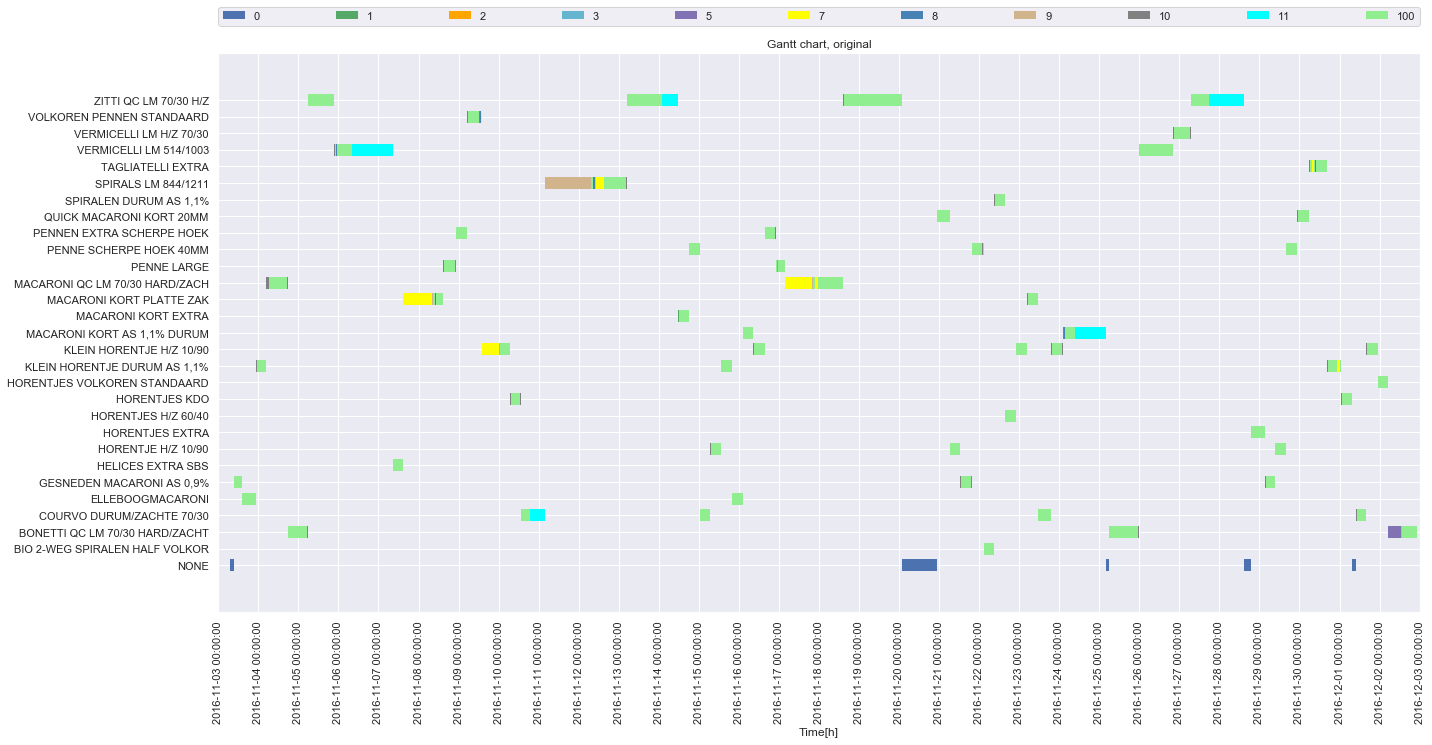

In [15]:
def show_gantt(start, end):
    plt.figure(figsize=(20, 10))
    # df_task['Start'] = (df_task.StartDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    # df_task['End'] = (df_task.EndDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    df_part = df_task[df_task.StartDateUTC.between(start, end) & df_task.EndDateUTC.between(start, end)]
    all_reasons = list(df_task.ReasonId.unique())
    all_reasons.sort()
    plot_gantt(df_part, 'ReasonId', 'ArticleName', order=all_reasons)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # key_list = sorted(by_label)
    # value_list = [by_label[key] for key in key_list]
    # plt.legend(value_list, key_list, loc='lower right')
    plt.title('Gantt chart, original')
    #try:
    #    plt.savefig('D:/temp/gantt.svg', dpi=1200, bbox_inches='tight')
    #except:
    #    pass
    plt.tight_layout()
    plt.show()
show_gantt(*plotrange)

In [16]:
def sliding_plot(start, ran):
    from datetime import datetime, timedelta

    plotrange = datetime(2016, 11, 2, 0, 0) + timedelta(start), datetime(2016, 11, 2, 0, 0) + timedelta(start+ran)

    show_gantt(*plotrange)

In [17]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

a = widgets.FloatText()
b = widgets.FloatSlider(min=0, max=100, step=1)
display(a)
c = widgets.FloatSlider(min=1, max=14, step=1)

mylink = widgets.jslink((a, 'value'), (b, 'value'))

interact(sliding_plot, start=b, ran=7)

FloatText(value=0.0)

interactive(children=(FloatSlider(value=0.0, description='start', step=1.0), IntSlider(value=7, description='ran', max=21, min=-7), Output()), _dom_classes=('widget-interact',))

<function __main__.sliding_plot>

In [18]:
#import os
#os.chdir(r'D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Revised')

In [19]:
def group_productions(df_task):
    group = df_task.groupby('ProductionRequestId').agg({'Quantity':'first','StartDateUTC':'min', 'EndDateUTC':'max', 'ArticleName':'first'}).sort_values(by='StartDateUTC')
    #print(len(group))
    group_uptime = df_task[df_task.ReasonId.isin([0, 100])].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_uptime.columns = ['Uptime']
    group_alltime = df_task.groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_alltime.columns = ['Totaltime']
    group_downtime = df_task[df_task.ReasonId.isin(considered_reasons)].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_downtime.columns = ['Downtime']
    group = pd.concat([group_uptime, group_downtime, group_alltime, group], axis=1)
    group = group.sort_values(by='StartDateUTC')
    group.index = group.index.astype(int)
    group = group.fillna(0)
    return group

def simplify_productions(group, num_minutes):
    df = group.copy()
    #df['Duration'] = df['Duration'] * 60
    #df['Duration'] = df['Duration'].apply(np.round).astype(int)
    #df['Duration'] = round(df['Duration'] / num_minutes) * num_minutes # rounds down to the chosen numbers of seconds
    i = 0
#    for j, k in zip(df.iloc[:-1].T, df.iloc[1:].T):
#         if i == 0:
#             df.loc[j, 'StartDateUTC'] = df.loc[j, 'StartDateUTC'].round(str(num_minutes) + 's')
#             df.loc[j, 'EndDateUTC'] = df.loc[j, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[j, 'Duration'])
#             i += 1
#         df.loc[k, 'StartDateUTC'] = df.loc[j, 'EndDateUTC']
#         df.loc[k, 'EndDateUTC'] = df.loc[k, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[k, 'Duration'])
#        df.loc[j, ]

    df['StartDateUTC'] = df['StartDateUTC'].dt.round(str(num_minutes) + 's')
    df['EndDateUTC'] = df['EndDateUTC'].dt.round(str(num_minutes) + 's')
    df['Duration'] = (df['EndDateUTC'] - df['StartDateUTC']).dt.total_seconds()
    df = df[df['Duration'] > 0]
    #df['Duration'] = df['Duration']/60
    return df

def remove_breaks(group, min_length=3600):
    df = group.copy()
    j = 0
    while j < len(df):
        temp = df.iloc[j]
        if (temp['ArticleName'] == 'NONE') & (temp['Totaltime'] < min_length):
            # don't turn off the machine (no energy saving)
            curidx = temp.name
            previdx = df.iloc[j-1].name
            if (j > 0): #& (df.loc[previdx, 'ArticleName'] != 'NONE'):
                # extend the previous job
                df.loc[previdx, 'EndDateUTC'] = df.loc[curidx, 'EndDateUTC']
                df.loc[previdx, 'Totaltime'] += df.loc[curidx, 'Totaltime']
                df.loc[previdx, 'Uptime'] += df.loc[curidx, 'Uptime']
                df.loc[previdx, 'Downtime'] += df.loc[curidx, 'Downtime']
                df = df.drop(curidx)
                j -= 1
            else:
                pass
                #print('Something unexpected happened!')
                #print(curidx, df.loc[previdx, 'ArticleName'])
        j += 1
    return df
                    

def save_durations(group, output, beforedays=None):
    out = group[['Uptime', 'Totaltime', 'Quantity', 'StartDateUTC', 'EndDateUTC', 'ArticleName']].copy()
    out.columns = ['Uptime', 'Totaltime', 'Quantity', 'Start', 'End', 'Product']
    out[['Uptime', 'Totaltime']] = out[['Uptime', 'Totaltime']] / 3600
    out = add_column_type(out , 'Product', 'PastaType')
    out.columns.values[-1] = 'Type'
    to_convert_dates = ['Start', 'End']
    if beforedays:
        out['Before'] = pd.to_datetime(out['End']) + pd.to_timedelta(beforedays, unit="D")
        to_convert_dates.append('Before')
    for col in to_convert_dates:
        out[col] = out[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    out.index.name = 'ID'
    out.to_csv(output)
    
def construct_downtimes(group, reasons):
    dt = group.copy()
    dt = dt[dt['ReasonId'].isin(reasons)]
    return dt

def save_downtimes(dt, output):
    out = dt.copy()
    out = out[['StartDateUTC', 'EndDateUTC']]
    out = out.reset_index(drop=True)
    out.index.name = 'ID'
    out.to_csv(output)

#print(len(df_task))
group = group_productions(df_task)
#print(len(group))
print(group.columns)
group = remove_breaks(group, 3600)
len(group)
#group = simplify_productions(group, 600)
#print(len(group))
downtime = construct_downtimes(df_task, considered_reasons)
save_downtimes(downtime, os.path.join(filepath,'historicalDownPeriods.csv'))

Index(['Uptime', 'Downtime', 'Totaltime', 'Quantity', 'StartDateUTC',
       'EndDateUTC', 'ArticleName'],
      dtype='object')


In [20]:
len(group)

2672

In [21]:
prodtime = group.Totaltime[group.ArticleName != 'NONE'].sum() / 3600
print('Production time {:.3f} h'.format(prodtime))
idletime = group.Totaltime[group.ArticleName == 'NONE'].sum() / 3600
print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 13296.306 h
Idle time 3043.893 h
Total time 16340.199 h


In [22]:
save_durations(group, os.path.join(filepath,'generated_jobInfoProd.csv'), beforedays=7)
# reasonlist = np.where(np.array(group['ArticleName']) == 'NONE', 0, 100) 
# group['ReasonId'] = reasonlist

In [56]:
def energy_per_production(group, file_speed):
    articlenum = len(group.ArticleName.unique())
    fs = pd.read_csv(file_speed, index_col=0)
    fs = fs[fs.ProductDescription.isin(list(group.ArticleName))]
    rand1 = np.random.random_sample((len(fs),)) * 0.2 + 0.1
    rand2 = np.random.random_sample((len(fs),)) * 0.05 + 0.05
    energycons = pd.concat([pd.Series(fs.ProductDescription), 
                            pd.Series(rand1), 
                            pd.Series(rand2), 
                            pd.Series(fs.TargetProductionRate)], axis=1)
    energycons.columns = ['Product', 'UnitPrice',  'Power', 'TargetProductionRate']
    #energycons.insert(1, 'UnitPrice', 5)
    #energycons.insert(len(energycons.columns), 'TargetProductionRate', 3000)
    #energycons.loc[energycons.Product == 'NONE', 'Power'] = 0
    energycons = energycons.append({'Product': 'NONE', 'UnitPrice': 0, 'Power': 0, 'TargetProductionRate': 0}, ignore_index=True)
    return energycons

energycons = energy_per_production(group, os.path.join(filepath, file_speed))
# energycons = add_column_type(energycons, 'Product', 'PastaType')
# energycons.columns.values[-1] = 'Type'
energycons.to_csv(os.path.join(filepath, 'generated_productRelatedCharacteristics.csv'), index=False)

In [57]:
energycons.head(50)

,Product,UnitPrice,Power,TargetProductionRate
0,BIO 2-WEG SPIRALEN HALF VOLKOR,0.140101,0.067726,6000
1,BIO COQUILLETTES,0.129458,0.057986,6000
2,BONETTI LM 897/384,0.183408,0.050832,3000
3,BONETTI QC LM 70/30 HARD/ZACHT,0.118642,0.091450,3000
4,COURVO DURUM/ZACHTE 70/30,0.201586,0.087107,6000
5,ELLEBOOGMACARONI,0.189546,0.073100,6000
6,"GESNEDEN MACARONI AS 0,9%",0.126006,0.056205,6000
7,HELICES EXTRA CESTINDUE,0.173294,0.088879,6000
8,HELICES EXTRA SBS,0.198480,0.064782,6000
9,HELICES GENERIEK,0.124616,0.099325,6000


In [58]:
startdate = group.StartDateUTC.min()
firstofmonth = (startdate - pd.offsets.MonthBegin(1)).floor('D')
enddate = group.StartDateUTC.max()
lastofmonth = (enddate + pd.offsets.MonthEnd(1)).ceil('D')
lastofmonth

def construct_energy_2tarifs(ran, daytarif, nighttarif, starttime, endtime):
    ind = pd.date_range(freq='H', start=ran[0], end=ran[1])
    prices = pd.DataFrame([daytarif] * len(ind), index=ind)

    night = (ind.weekday >= 5) | (ind.hour < endtime) | (ind.hour >= starttime) # saturday or sunday, after 21 and before 6
    prices[night] = nighttarif
    prices.columns = ['Euro']
    prices.index.name = 'Date'
    #prices = prices.loc[prices['Euro'].diff(1) != 0]
    return prices

prices = construct_energy_2tarifs((firstofmonth, lastofmonth), 12, 8, 21, 6)
prices.to_csv(os.path.join(filepath, 'generated_hourly_energy_price.csv'))
prices.head()

,Euro
Date,
2016-01-01 00:00:00,8
2016-01-01 01:00:00,8
2016-01-01 02:00:00,8
2016-01-01 03:00:00,8
2016-01-01 04:00:00,8


In [59]:
def calculate_energy_cost(df_tasks, df_cost, df_cons, return_table=False):
    lastenddate = df_tasks.iloc[-1]['EndDateUTC']
    new_row = pd.Series({'ProductionRequestId': -1000,
                     'StartDateUTC': lastenddate,
                     'EndDateUTC': lastenddate + pd.Timedelta(1, 's'),
                     'Duration': 1,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
    df_tasks = df_tasks.append(new_row, ignore_index=True)
    #print(df_tasks)
    
    # Set timedateindex
    df_tasks = df_tasks.merge(df_cons, how='left', left_on='ArticleName', right_on='Product').set_index('StartDateUTC', drop=True)
    
    # Concatenate the list of tasks and the energy cost on axis 0
    out_table = pd.concat([df_tasks, df_cost]).sort_index()
    out_table = out_table[df_tasks.index[0]: df_tasks.index[-1]]
    
    
    # Determine the length of each time interval
    # Make a new index with all changes and their length in hours
    alldates = out_table.index
    times = -pd.Series(((alldates - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s'))).diff(-1)
    out_table = out_table.reset_index(drop=True)
    out_table['Difftime'] = times
    out_table.index = alldates
    out_table = out_table.iloc[:-1]
    out_table = out_table[['Product', 'Difftime', 'Euro', 'Power']].ffill().bfill()

    out_table = out_table[out_table.Difftime > 0]
    
    out_table['Price'] = (out_table['Difftime'] * out_table['Euro'] * out_table['Power']) / 3600
    total_sum = out_table['Price'].sum()
    
    if return_table:
        return total_sum, out_table
    else:
        return total_sum

In [60]:
group.head()

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName
ProductionRequestId,,,,,,,
50675,18996.0,655.0,19651.0,30000.0,2016-01-19 14:21:47.980,2016-01-19 19:49:18.047,MACARONI KORT PLATTE ZAK
-1,7200.0,0.0,7200.0,0.0,2016-01-19 19:49:18.047,2016-01-19 21:49:18.047,NONE
-2,7200.0,0.0,7200.0,0.0,2016-01-19 21:49:18.047,2016-01-19 23:49:18.047,NONE
-3,7200.0,0.0,7200.0,0.0,2016-01-19 23:49:18.047,2016-01-20 01:49:18.047,NONE
-4,7200.0,0.0,7200.0,0.0,2016-01-20 01:49:18.047,2016-01-20 03:49:18.047,NONE


In [61]:
downtime.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName,Quantity
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK,30000
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK,30000
4,50675,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177,10,MACARONI KORT PLATTE ZAK,30000
26,50724,2016-01-21 09:56:44.780,2016-01-21 09:58:50.930,126,9,"GESNEDEN MACARONI AS 0,9%",30000
28,50724,2016-01-21 10:51:08.090,2016-01-21 10:56:02.120,294,8,"GESNEDEN MACARONI AS 0,9%",30000


In [62]:
plotrange

(datetime.datetime(2016, 11, 3, 6, 0), datetime.datetime(2016, 12, 3, 0, 0))

In [63]:
#group_part.tail(10)

C:\Users\jdavid\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

-1491


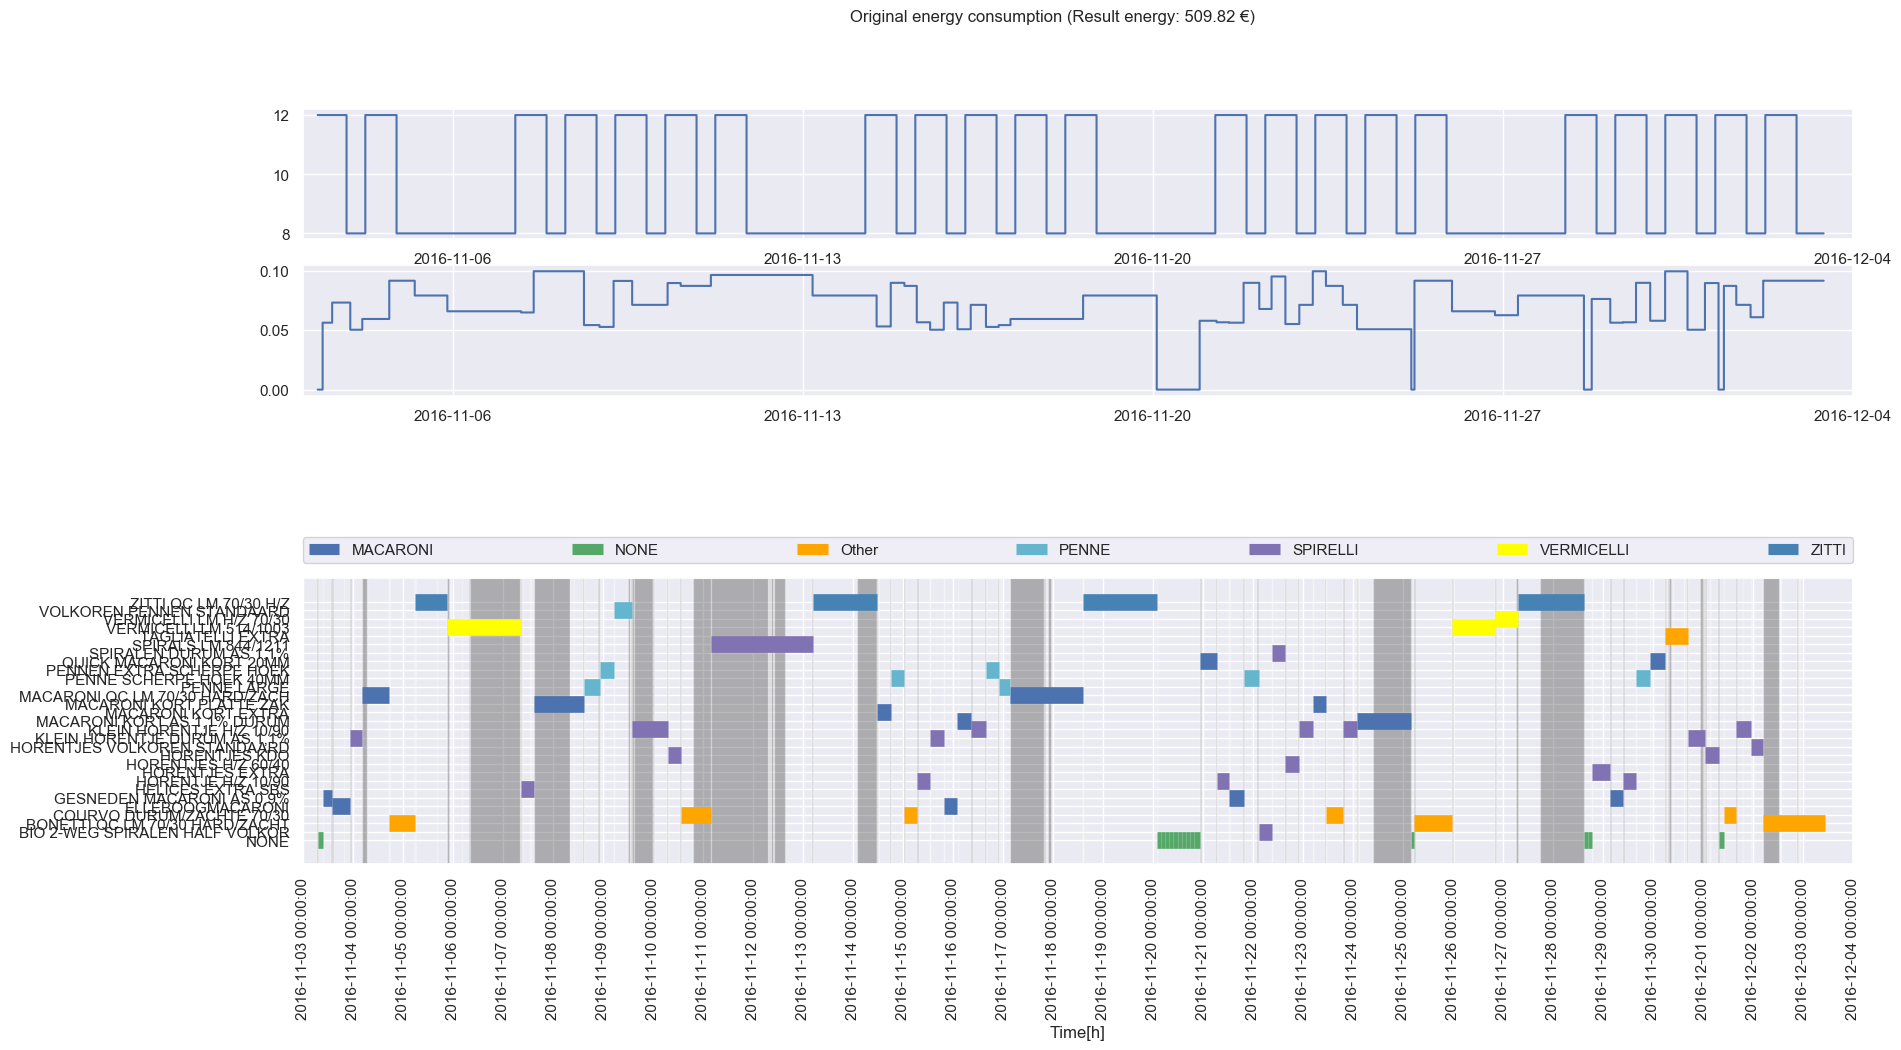

In [64]:
group_part = group[group.StartDateUTC.between(*plotrange)]
downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

plt.figure(figsize=(20, 10), dpi=100)
c, table = calculate_energy_cost(group_part, prices, energycons, True)

plt.subplot(5,1,(4,5))
timerange = plot_gantt(add_column_type(group_part, choice='PastaType'), 'PastaType', 'ArticleName', downtimes=downtime_temp)
plt.subplot(5,1,1)
plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(5,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')
try:
    plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
except:
    print('No output made.')
    pass
plt.show()

In [65]:
break

SyntaxError: 'break' outside loop (<ipython-input-65-6aaf1f276005>, line 1)

In [66]:
# start_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).min())
# end_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).max())
# start_time, end_time

In [67]:
from SchedulerV000 import run_opt
files = [os.path.join(filepath, f) for f in ['generated_productRelatedCharacteristics.csv', 'generated_hourly_energy_price.csv', 'generated_jobInfoProd.csv']]
best_result, orig_result, best_sched, orig_sched, best_curve, worst_curve, gen = run_opt(*plotrange, 
       [], [],
        *files, 
        1, 2000, 0.4, 0.4, 12, num_mutations=1, adaptive=[],
        stop_condition='num_iterations', stop_value=None, 
        weight_energy = 1, weight_failure=0, weight_conversion = 1, weight_before = 0)

Unexpected error when reading down duration information from '[]'


D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\SchedulerV000.py:1288: UserWarning: Import of downtime durations failed, using scheduling without failure information.
  warnings.warn('Import of downtime durations failed, using scheduling without failure information.')


For candidate schedule: [62260 62253 62259 -1522 62214 62215 62218 62630 63070 62523 -1515 62753
 61962 63133 62179 62622 -1519 63062 62217 62529 62729 63056 -1518 62216
 62258 62984 62854 62231 62788 -1540 62985 62628 62495 -1513 62465 62848
 62496 62805 62497 62898 63181 63151 62623 62402 63089 62082 -1491 62789
 -1531 62769 -1520 -1516 63169 62904 62024 62022 -1536 62983 62899 62023
 61892 -1535 62528 62850 62763 -1514 -1521 -1517 63110 62384 62945]
Job 62082 will finish at 2016-11-17 14:27:13.419000 over the due date 2016-11-10 22:47:19.140000
For candidate schedule: [62789 -1513 -1536 62983 62179 63169 62805 62497 62788 -1518 62214 62763
 -1520 62496 63062 62253 63089 -1517 62215 -1531 63133 -1540 61962 62260
 -1514 62623 62622 62231 62769 62495 -1516 62850 62402 62848 62216 62753
 62023 -1522 62082 63181 62899 63110 63070 62898 62628 62024 62218 63151
 62022 62258 62217 62529 -1519 62945 62528 62465 -1535 62904 62523 63056
 -1491 -1521 62984 62630 -1515 62985 62854 61892 62729 62

For candidate schedule: [62789 -1536 62983 62179 62805 62788 62214 62496 -1531 -1540 -1514 62623
 62495 -1516 62402 62023 63181 63110 63070 62022 62258 62217 62528 62465
 62904 62523 63056 -1521 -1515 62985 62854 61892 62260 62253 62259 -1522
 62215 62218 62630 62753 61962 63133 62622 -1519 63062 62529 62729 -1518
 62216 62984 62231 62628 -1513 62848 62497 62898 63151 63089 62082 -1491
 62769 -1520 63169 62024 62899 -1535 62850 62763 -1517 62384 62945]
Job 61962 will finish at 2016-11-15 07:31:09.633000 over the due date 2016-11-10 14:05:35.653000
For candidate schedule: [62789 -1513 -1536 62983 62179 63169 62805 62497 62788 -1518 62214 62763
 -1520 62496 63062 62253 63089 -1517 62215 -1531 63133 -1540 61962 62260
 -1514 62623 62622 62231 62769 62495 -1516 62850 62402 62848 62216 62753
 62023 -1522 62082 63181 62899 63110 63070 62898 62628 62024 62218 63151
 62022 62258 62217 62529 -1519 62945 62528 62465 -1535 62904 62523 63056
 -1491 -1521 62984 62630 -1515 62985 62854 61892 62729 62

For candidate schedule: [62529 62898 62497 -1522 -1491 62258 62465 62179 62854 62763 62259 62630
 62753 62623 63181 62729 62214 63070 62082 62985 62384 -1531 62402 63151
 -1514 -1516 63062 62899 62850 62788 62984 63056 -1519 62983 62253 62789
 62217 61892 62523 62805 62023 62622 63089 62216 -1521 -1517 -1515 62024
 62260 -1536 63169 -1513 62628 61962 -1520 62528 -1540 62769 -1518 62495
 63133 -1535 62496 62022 62848 62215 62218 62904 62231 62945 63110]
Job 62253 will finish at 2016-11-15 02:48:39.342000 over the due date 2016-11-14 14:49:48.377000
For candidate schedule: [-1536 62984 63110 63169 -1514 62218 -1520 62528 62497 62495 62214 -1531
 62628 62763 63056 62769 62529 62898 63070 62729 62985 -1517 62523 62215
 62850 62024 63089 61892 62622 -1521 -1519 62258 62179 -1516 62805 62848
 62788 62082 62260 62384 -1491 62465 62253 62623 62231 -1535 61962 62630
 63181 62496 -1540 62259 62216 -1522 62023 62753 62983 62217 -1513 62945
 62899 62854 62904 63133 -1518 62022 -1515 62789 63062 63

For candidate schedule: [62253 63133 62898 62384 62622 62523 63110 62763 62850 62258 -1518 62022
 62214 62984 -1535 63062 63169 -1522 62983 62216 62217 61962 -1536 62529
 63181 62769 62218 62630 62985 -1531 62945 62628 62024 62904 62402 62788
 62789 -1516 62854 62260 -1519 62215 -1517 -1514 61892 62023 62179 62805
 62528 62495 62259 62729 62497 62753 62623 63070 -1515 63056 -1540 62496
 63151 62082 63089 62899 62465 -1491 62231 -1513 -1520 -1521 62848]
Job 62024 will finish at 2016-11-13 11:44:05.183000 over the due date 2016-11-12 05:43:35.140000
For candidate schedule: [62024 62628 62082 62215 62622 62805 -1517 63169 -1518 -1540 62850 62218
 62523 62529 -1520 62217 62984 62528 62253 62260 -1531 62259 -1535 62496
 62898 62789 62848 63062 63089 -1516 -1536 63110 61892 62497 62258 62899
 62384 63070 62985 62945 62854 62623 -1522 63133 62214 -1521 62231 -1491
 -1515 63151 62763 62402 62023 62729 62904 63181 63056 62465 62788 62495
 62630 62769 62753 62983 62216 62179 -1513 -1514 61962 62

For candidate schedule: [62945 63070 62630 62622 -1536 62854 -1515 62983 63133 62623 62215 62850
 62529 62179 63062 62214 62231 62023 62082 62789 62497 62805 -1513 61892
 62769 62217 62495 62528 -1519 -1518 62899 63056 63151 62753 62260 63110
 62788 62985 63181 62496 62024 -1520 62216 -1516 -1491 -1540 -1517 -1531
 62022 -1521 62628 -1535 62218 61962 62984 62729 -1514 62253 -1522 63089
 62523 62402 62898 62258 62904 62259 62763 62465 63169 62848 62384]
Job 62024 will finish at 2016-11-16 16:06:51.960000 over the due date 2016-11-12 05:43:35.140000
For candidate schedule: [62805 62904 62769 62788 61892 62622 62729 63151 62082 62024 62218 -1521
 62497 -1513 62214 -1536 -1517 62850 62854 62528 62983 -1522 62496 62465
 63110 62623 62259 62945 62217 62789 62179 63169 -1518 62763 -1520 63062
 62253 63089 62215 -1531 63133 -1540 61962 62260 -1514 62231 62495 -1516
 62402 62848 62216 62753 62023 63181 62899 63070 62898 62628 62022 62258
 62529 -1519 -1535 62523 63056 -1491 62984 62630 -1515 62

For candidate schedule: [-1536 62984 63110 63169 -1514 62218 -1520 62528 62497 62495 62214 -1531
 62628 62763 63056 62769 62529 62898 63070 62729 62985 -1517 62523 62215
 62850 62024 63089 61892 62622 -1521 -1519 62258 62179 -1516 62805 62848
 62788 62082 62260 62384 -1491 62465 62253 62623 62231 -1535 61962 62630
 63181 62496 -1540 62259 62216 -1522 62023 62753 62983 62217 -1513 62945
 62899 62854 62904 63133 -1518 62022 -1515 62789 63062 63151 62402]
Job 62179 will finish at 2016-11-12 13:16:12.529000 over the due date 2016-11-11 04:32:24.930000
For candidate schedule: [62623 -1520 62788 -1522 62218 62402 63089 62495 62465 62528 62630 62179
 62789 61962 62628 62253 63133 62984 62753 63110 62082 63062 62216 62259
 62384 -1536 62496 62258 62217 62622 -1519 62769 -1518 62899 62983 63056
 62529 63151 62260 62985 63181 62024 -1516 -1491 -1540 -1517 -1531 62022
 -1521 62854 63070 -1535 62805 62231 61892 62945 62729 -1514 62215 62850
 62523 62898 -1515 -1513 62904 62023 62497 62763 63169 62

For candidate schedule: [62529 62898 -1491 62258 62179 62854 62259 63181 62729 62214 63070 62985
 62983 -1531 62402 -1514 -1516 63062 62899 62984 63056 62253 62217 62523
 62805 62023 -1515 62260 62628 -1520 -1518 63133 62496 62022 62215 62231
 62945 62630 62528 62622 62497 -1513 62024 61892 62082 62216 -1519 62495
 62753 62769 61962 -1535 62788 62384 62789 62465 62218 -1521 -1517 -1536
 -1540 63151 63110 63089 62904 62763 62848 63169 -1522 62623 62850]
Job 62022 will finish at 2016-11-12 15:44:44.947000 over the due date 2016-11-11 17:29:54.697000
For candidate schedule: [62260 62253 62259 -1522 62214 62215 62218 62630 63070 62523 -1515 62753
 61962 63133 62179 62622 -1519 63062 62217 62529 62729 63056 -1518 62216
 62258 62984 62854 62231 62788 -1540 62985 62628 62495 -1513 62465 62848
 62496 62805 62497 62898 63181 63151 62623 62402 63089 62082 -1491 62789
 -1531 62769 -1520 -1516 63169 62904 62024 62022 -1536 62983 62899 62023
 61892 -1535 62528 62850 62763 -1514 -1521 -1517 63110 62

For candidate schedule: [-1536 62984 63110 63169 -1520 62528 62497 62495 62214 -1531 63056 62769
 -1517 62850 62024 62622 62082 62260 62253 62231 -1535 62630 62496 -1540
 62259 62216 -1522 62753 62983 62217 -1513 62945 62899 62854 62789 62402
 -1519 62023 62529 63151 62179 62788 62985 63181 62623 -1516 -1491 62022
 63133 63062 -1521 62628 63070 62218 61962 62805 61892 62729 -1514 62215
 63089 62523 62898 62258 -1515 62904 -1518 62763 62465 62848 62384]
Job 62179 will finish at 2016-11-15 01:28:02.614000 over the due date 2016-11-11 04:32:24.930000
For candidate schedule: [62622 62805 62850 62529 -1520 62217 62984 -1531 63089 -1516 -1536 63110
 62497 62899 62384 -1522 63133 62231 -1491 63151 62763 62904 63056 62495
 62983 -1513 61962 -1519 62630 62528 62985 62854 62022 62729 62023 62024
 61892 62523 62082 62216 -1514 62628 62753 62769 -1535 62259 62788 62214
 62789 63181 62465 62179 62496 -1515 -1521 -1517 -1540 62898 62258 62218
 62945 63062 62848 62215 62253 63070 62260 63169 62623 -1

For candidate schedule: [62260 62253 62753 -1522 62214 62215 62218 62630 63070 62523 -1515 62259
 61962 63133 62179 62622 -1519 63062 62217 62529 62729 63056 -1518 62216
 62258 62984 62854 62231 62788 -1540 62985 62628 62495 -1513 62465 62848
 62496 62805 62497 62898 63181 63151 62623 62402 63089 62082 -1491 62789
 -1531 62769 -1520 -1516 63169 62904 62024 62022 -1536 62983 62899 62023
 61892 -1535 62528 62850 62763 -1514 -1521 -1517 63110 62384 62945]
Job 62082 will finish at 2016-11-17 14:27:13.419000 over the due date 2016-11-10 22:47:19.140000
For candidate schedule: [62253 -1522 62214 62215 62218 63070 62523 61962 63133 62179 62622 -1519
 63062 63056 -1518 62216 62984 62854 -1540 62628 62495 62805 62497 63181
 62623 63089 -1491 62789 -1531 -1520 62904 -1536 62899 -1535 62850 62763
 -1514 -1517 63110 62384 62630 62528 62529 62231 62985 62022 62729 -1516
 -1513 62023 62024 61892 62082 62753 62769 62259 62788 62983 62465 62496
 -1515 -1521 63151 62898 62258 62945 62848 62260 63169 62

KeyboardInterrupt: 

In [80]:
best_sched = list(best_sched.keys())

NameError: name 'best_sched' is not defined

In [278]:
def reorder_schedule(id_list, schedule):
    df = schedule.loc[id_list]
    startdate = df['StartDateUTC'].min()
    #print(df)
    for row in df.T:
        df.loc[row, 'StartDateUTC'] = startdate
        enddate = startdate + pd.Timedelta(df.loc[row, 'Totaltime'], unit='s')
        df.loc[row, 'EndDateUTC'] = enddate
        startdate = enddate
    return df

In [279]:
group_opt = reorder_schedule(best_sched, group)
reasonlist = np.where(np.array(group_opt['ArticleName']) == 'NONE', 0, 100) 
group_opt['ReasonId'] = reasonlist
group_opt.head()

,Uptime,Downtime,Totaltime,StartDateUTC,EndDateUTC,ArticleName,ReasonId
ProductionRequestId,,,,,,,
-1531,5448.227,0.0,5448.227,2016-11-03 07:08:12.890,2016-11-03 08:39:01.117,NONE,0
-1518,7200.000,0.0,7200.000,2016-11-03 08:39:01.117,2016-11-03 10:39:01.117,NONE,0
63133,30625.000,8043.0,38668.000,2016-11-03 10:39:01.117,2016-11-03 21:23:29.117,TAGLIATELLI EXTRA,100
62216,23656.987,3191.0,26847.987,2016-11-03 21:23:29.117,2016-11-04 04:50:57.104,PENNE LARGE,100
-1536,6236.610,0.0,6236.610,2016-11-04 04:50:57.104,2016-11-04 06:34:53.714,NONE,0


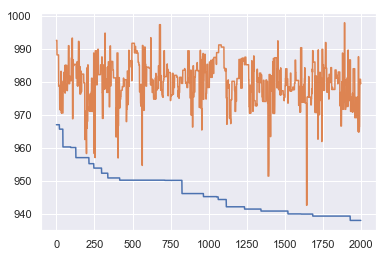

In [280]:
plt.plot(best_curve)
plt.plot(worst_curve)

In [281]:
group_opt.head(10)

,Uptime,Downtime,Totaltime,StartDateUTC,EndDateUTC,ArticleName,ReasonId
ProductionRequestId,,,,,,,
-1531,5448.227,0.0,5448.227,2016-11-03 07:08:12.890,2016-11-03 08:39:01.117,NONE,0
-1518,7200.000,0.0,7200.000,2016-11-03 08:39:01.117,2016-11-03 10:39:01.117,NONE,0
63133,30625.000,8043.0,38668.000,2016-11-03 10:39:01.117,2016-11-03 21:23:29.117,TAGLIATELLI EXTRA,100
62216,23656.987,3191.0,26847.987,2016-11-03 21:23:29.117,2016-11-04 04:50:57.104,PENNE LARGE,100
-1536,6236.610,0.0,6236.610,2016-11-04 04:50:57.104,2016-11-04 06:34:53.714,NONE,0
62529,20576.587,1472.0,22048.587,2016-11-04 06:34:53.714,2016-11-04 12:42:22.301,PENNEN EXTRA SCHERPE HOEK,100
62630,61262.910,64229.0,125491.910,2016-11-04 12:42:22.301,2016-11-05 23:33:54.211,MACARONI QC LM 70/30 HARD/ZACH,100
62729,72858.987,1391.0,74249.987,2016-11-05 23:33:54.211,2016-11-06 20:11:24.198,VERMICELLI LM 514/1003,100
62384,76418.003,34231.0,110649.003,2016-11-06 20:11:24.198,2016-11-08 02:55:33.201,ZITTI QC LM 70/30 H/Z,100


-1531


C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


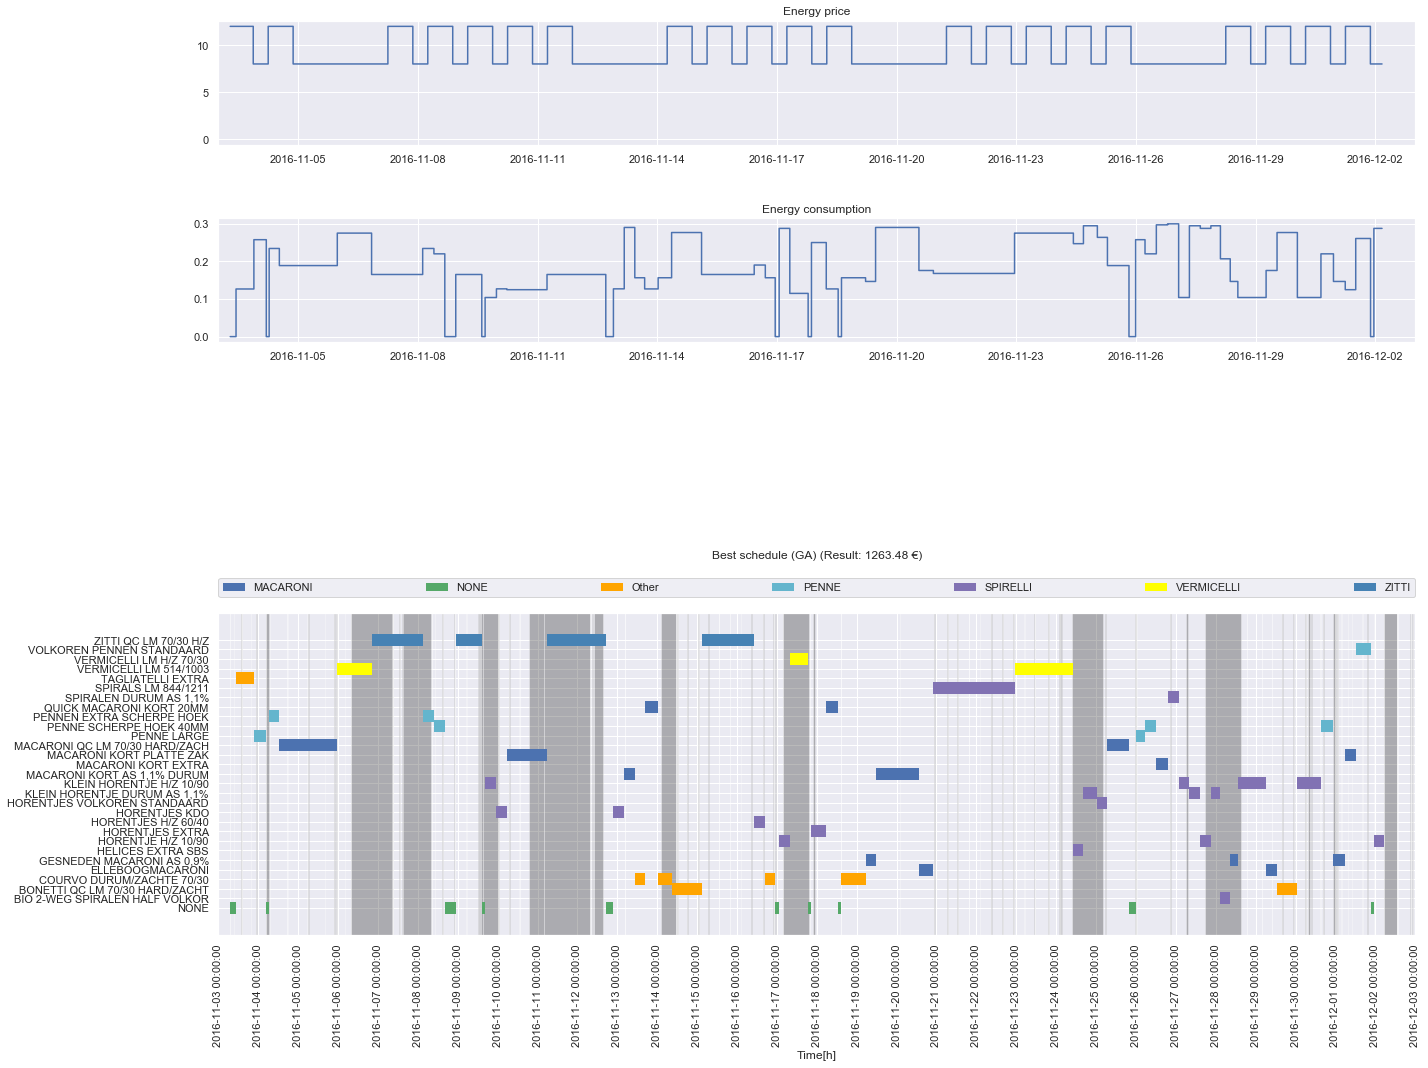

In [296]:
plt.figure(figsize=(20, 15))
show_energy_plot(add_column_type(group_opt, choice=choice), prices, energycons, 'Best schedule (GA)', 'PastaType', downtimes=downtime_temp)
plt.show()

In [283]:
# group_part = group_opt[group_opt.StartDateUTC.between(*plotrange)]
# downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

# plt.figure(figsize=(20, 10))
# c, table = calculate_energy_cost(group_part, prices, energycons, True)

# plt.subplot(5,1,(4,5))
# timerange = plot_gantt(add_column_type(group_part, choice='PastaType'), 'PastaType', 'ArticleName', downtimes=downtime_temp)
# plt.subplot(5,1,1)
# plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Euro, drawstyle='steps-post')

# plt.subplot(5,1,2)
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Power, drawstyle='steps-post')
# try:
#     plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
# except:
#     print('No output made.')
#     pass
# plt.show()

In [284]:
# df_task = df[['StartDateUTC', 'EndDateUTC', 'ArticleName', 'Type']]
# df_task.columns = ['Start', 'Finish', 'Task', 'Resource']
# df_task = df_task.iloc[1:2000]
# df_task = df_task.reset_index(drop=True)
# df_task.head()

In [285]:
# df_task.Resource.unique()

In [286]:
# import plotly.plotly as py
# import plotly.figure_factory as ff
# # colors = {'DownTime': 'rgb(220, 0, 0)',
# #           'RunTime': 'rgb(0, 255, 100)',
# #          'Break': 'rgb(255, 230, 25)'}
# fig = ff.create_gantt(df_task, group_tasks=True, show_colorbar=True)
# py.iplot(fig, world_readable=True)

In [287]:
#     df_temp = df[]
#     from probdist import duration_between_downtime
#     bool_up = (df.Type == 'RunTime') # List of all RunTimes
#     bool_down = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
#     # Will ignore types of DownTimes not in the list
#     duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600 # hours